# Evolution of NBA Player Salary Determinants Over the Last 30 Years

As a longtime NBA fan, I have been curious for a while as to how NBA player contracts are determined, and which factors play the biggest part in determining the size of a contract that a player will get. Specifically in the modern NBA, 3-point shooting has become much more common, and most of the current highest-payed players are excellent 3-point shooters. For this project, I decided to take a look at how the NBA has evolved in the last 30 years in regards to determinants for a player's contract, with a focus on 3-point shooting.

In [1]:
# import packages and set themes
! pip install chart-studio

import numpy as np
import pandas as pd
import qeds
import requests

import plotly as pt
import plotly.express as px
from chart_studio.plotly import plot, iplot as py
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode

import seaborn as sns
import matplotlib.colors as mplc
import matplotlib.pyplot as plt

from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)

%matplotlib inline
# activate plot theme
qeds.themes.mpl_style();
colors = qeds.themes.COLOR_CYCLE

The first dataset contains all basketball statistics for all NBA players through each season.

In [2]:
df = pd.read_csv("nba_player_data.csv")

df

seas_id  season  player_id          player  birth_year    hof  pos  \
0        28943    2021       4219    Aaron Gordon         NaN  False   PF   
1        28944    2021       4219    Aaron Gordon         NaN  False   PF   
2        28945    2021       4219    Aaron Gordon         NaN  False   PF   
3        28946    2021       4582   Aaron Holiday         NaN  False   PG   
4        28947    2021       4805   Aaron Nesmith         NaN  False   SF   
...        ...     ...        ...             ...         ...    ...  ...   
29607      200    1947        157     Walt Miller         NaN  False    F   
29608      201    1947        158   Warren Fenley         NaN  False    F   
29609      202    1947        159   Wilbert Kautz         NaN  False  G-F   
29610      203    1947        160  Woody Grimshaw         NaN  False    G   
29611      204    1947        161     Wyndol Gray         NaN  False  G-F   

        age  experience   lg  ... ft_percent  orb_per_game  drb_per_game  \
0      25.0           7  NBA  ...      0.646           1.5           4.5   
1      25.0           7  NBA  ...      0.629           1.6           5.1   
2      25.0           7  NBA  ...      0.727           1.3           3.3   
3      24.0           3  NBA  ...      0.783           0.2           1.1   
4      21.0           1  NBA  ...      0.688           0.5           1.6   
...     ...         ...  ...  ...        ...           ...           ...   
29607  31.0           1  BAA  ...      0.500           NaN           NaN   
29608  24.0           1  BAA  ...      0.511           NaN           NaN   
29609  31.0           1  BAA  ...      0.534           NaN           NaN   
29610  27.0           1  BAA  ...      0.477           NaN           NaN   
29611  24.0           1  BAA  ...      0.581           NaN           NaN   

       trb_per_game  ast_per_game  stl_per_game  blk_per_game  tov_per_game  \
0               6.0           3.7           0.7           0.8           2.2   
1               6.6           4.2           0.6           0.8           2.7   
2               4.5           2.5           0.8           0.6           1.1   
3               1.2           1.6           0.6           0.2           0.9   
4               2.1           0.3           0.3           0.2           0.5   
...             ...           ...           ...           ...           ...   
29607           NaN           0.5           NaN           NaN           NaN   
29608           NaN           0.5           NaN           NaN           NaN   
29609           NaN           0.7           NaN           NaN           NaN   
29610           NaN           0.0           NaN           NaN           NaN   
29611           NaN           0.9           NaN           NaN           NaN   

       pf_per_game  pts_per_game  
0              1.9          13.6  
1              2.0          14.6  
2              1.6          11.5  
3              1.6           7.3  
4              1.4           3.3  
...            ...           ...  
29607          1.3           1.9  
29608          1.8           2.6  
29609          2.3           5.1  
29610          1.2           2.9  
29611          1.9           6.4  

[29612 rows x 36 columns]

This doesn't include any player salaries or salary cap information, so I will need to combine a few more datasets to add in that information.

In [3]:
salary_cap_df = pd.read_csv("nba_historical_salary_cap.csv")
salary_cap_df.head()

Year   Salary Cap      Adjusted
0  1985  $3,600,000    $8,557,797 
1  1986  $4,233,000    $9,873,144 
2  1987  $4,945,000   $11,128,422 
3  1988  $6,164,000   $13,325,270 
4  1989  $7,232,000   $14,916,364

In [4]:
big_salary_data = pd.read_csv('player_salary_history.csv')
big_salary_data

YearEnd                Team            Player       Salary  BelowMin  \
0         2017       Atlanta Hawks     Dwight Howard   23,180,275       NaN   
1         2017       Atlanta Hawks      Paul Millsap   20,072,033       NaN   
2         2017       Atlanta Hawks     Kent Bazemore   15,730,338       NaN   
3         2017       Atlanta Hawks    Tiago Splitter    8,550,000       NaN   
4         2017       Atlanta Hawks       Kyle Korver    5,239,437       NaN   
...        ...                 ...               ...           ...      ...   
12710     1991  Washington Bullets      Harvey Grant      475,000       NaN   
12711     1991  Washington Bullets       Byron Irvin      375,000       NaN   
12712     1991  Washington Bullets      A.J. English      275,000       NaN   
12713     1991  Washington Bullets       Greg Foster      275,000       NaN   
12714     1991  Washington Bullets  Haywoode Workman      120,000       NaN   

       Unnamed: 5  
0               1  
1               2  
2               0  
3               0  
4               0  
...           ...  
12710           0  
12711           0  
12712           0  
12713           0  
12714           0  

[12715 rows x 6 columns]

In [5]:
salary2018 = pd.read_csv('salary2018.csv')
salary2019 = pd.read_csv('salary2019.csv')
salary2020 = pd.read_csv('salary2020.csv')

It looks like we have a lot of data cleaning and merging ahead of us to combine these datasets, so let's get started.

In [6]:
# Data cleaning #

clean_cap = salary_cap_df.drop('Adjusted', axis = 1)
clean_cap['Salary Cap'] = clean_cap['Salary Cap'].str.replace(',', '')
clean_cap['Salary Cap'] = clean_cap['Salary Cap'].str.replace('$', '')
clean_cap['Year'] = clean_cap['Year'].str.replace("'", '')

clean_cap.dtypes

Year          object
Salary Cap    object
dtype: object

In [7]:
clean_cap['Year'] = pd.to_numeric(clean_cap['Year'])
clean_cap['Salary Cap'] = pd.to_numeric(clean_cap['Salary Cap'])
clean_cap.head(10)

Year  Salary Cap
0  1985     3600000
1  1986     4233000
2  1987     4945000
3  1988     6164000
4  1989     7232000
5  1990     9802000
6  1991    11871000
7  1992    12500000
8  1993    14000000
9  1994    15175000

In [8]:
clean_bigsalary = big_salary_data.drop(['Team', 'BelowMin', 'Unnamed: 5'], axis=1)
cleaned = clean_bigsalary.rename(columns = {'YearEnd': 'Year', ' Salary ': 'Salary'})
cleaned['Salary'] = cleaned['Salary'].str.replace(',', '')
cleaned

Year            Player      Salary
0      2017     Dwight Howard   23180275 
1      2017      Paul Millsap   20072033 
2      2017     Kent Bazemore   15730338 
3      2017    Tiago Splitter    8550000 
4      2017       Kyle Korver    5239437 
...     ...               ...         ...
12710  1991      Harvey Grant     475000 
12711  1991       Byron Irvin     375000 
12712  1991      A.J. English     275000 
12713  1991       Greg Foster     275000 
12714  1991  Haywoode Workman     120000 

[12715 rows x 3 columns]

In [9]:
cleaned['Salary'] = cleaned['Salary'].str.replace('Unknown', '0')
cleaned['Salary'] = pd.to_numeric(cleaned['Salary'])
cleaned.dtypes

Year       int64
Player    object
Salary     int64
dtype: object

In [10]:
clean_salary2018 = salary2018.drop('Unnamed: 0', axis=1)
clean_salary2018['Salary'] = clean_salary2018['Salary'].str.replace(',', '')
clean_salary2018['Salary'] = clean_salary2018['Salary'].str.replace('$', '')
clean_salary2018_v2 = clean_salary2018.rename(columns = {'Season': 'Year'})
clean_salary2018_v2['Salary'] = pd.to_numeric(clean_salary2018_v2['Salary'])
clean_salary2018_v2

Player    Salary  Year
0          Stephen Curry  34682550  2018
1           LeBron James  33285709  2018
2           Paul Millsap  30769231  2018
3         Gordon Hayward  29727900  2018
4          Blake Griffin  29512900  2018
..                   ...       ...   ...
581         Andre Ingram     46079  2018
582  Trey McKinney-Jones     46079  2018
583        Aaron Jackson     46079  2018
584        Jameel Warney     46079  2018
585   Marcus Thornton II     46079  2018

[586 rows x 3 columns]

In [11]:
clean_salary2019 = salary2019.drop('Unnamed: 0', axis=1)
clean_salary2019['Salary'] = clean_salary2019['Salary'].str.replace(',', '')
clean_salary2019['Salary'] = clean_salary2019['Salary'].str.replace('$', '')
clean_salary2019['Salary'] = pd.to_numeric(clean_salary2019['Salary'])

In [12]:
clean_salary2020 = salary2020.drop('Unnamed: 0', axis=1)
clean_salary2020['Salary'] = clean_salary2020['Salary'].str.replace(',', '')
clean_salary2020['Salary'] = clean_salary2020['Salary'].str.replace('$', '')
clean_salary2020['Salary'] = pd.to_numeric(clean_salary2020['Salary'])

Now that the five salary data frames are cleaned and have the same column names, I can combine them together.

In [13]:
# Combine all salary and salary cap dataframes
merge1 = pd.concat([clean_salary2018_v2, cleaned], axis=0)
merge1

merge2 = pd.concat([clean_salary2019, merge1], axis=0)
merge2

merge3 = pd.concat([clean_salary2020, merge2], axis=0)
merge3

merge4 = pd.merge(clean_cap, merge3, on='Year')
merge4

print(merge4.dtypes)
merge4

Year           int64
Salary Cap     int64
Player        object
Salary         int64
dtype: object


Year  Salary Cap             Player   Salary
0      1991    11871000       Moses Malone  2406000
1      1991    11871000  Dominique Wilkins  2065000
2      1991    11871000         Jon Koncak  1550000
3      1991    11871000         Doc Rivers   895000
4      1991    11871000    Rumeal Robinson   800000
...     ...         ...                ...      ...
14384  2020   109140000    Jeremiah Martin    79568
14385  2020   109140000     Tremont Waters    79568
14386  2020   109140000         Tacko Fall    79568
14387  2020   109140000      Charlie Brown    79568
14388  2020   109140000       Malik Newman    65978

[14389 rows x 4 columns]

For our purposes, most of these columns won't be used in our calculations and can be dropped from the data. Additionally, a lot of data from 1947-1979 is fragmented and includes players from the ABA and BAA, so I will limit my data from seasons after 1991.

In [14]:
# Drop rows and combine player and salary data
clean_data = df.drop(['seas_id', 'hof', 'lg', 'pos', 'birth_year', 'gs', 'fg_per_game', 'fga_per_game', 'fg_percent'], axis=1) 
clean_data2 = clean_data.drop(['x2p_per_game', 'x2pa_per_game', 'x2p_percent', 'x3p_percent', 'e_fg_percent', 'ft_per_game', 'fta_per_game', 'ft_percent', 'orb_per_game', 'drb_per_game'], axis=1)
capitalized = clean_data2.rename(columns = {'season' : 'Year', 'player' : 'Player'})
modern_data = capitalized.loc[capitalized["Year"] > 1990]

merge5 = pd.merge(modern_data, merge4, on=['Year', 'Player'])
merge5

Year  player_id             Player   age  experience   tm     g  \
0      2020       4219       Aaron Gordon  24.0           6  ORL  62.0   
1      2020       4582      Aaron Holiday  23.0           2  IND  66.0   
2      2020       4463        Abdel Nader  26.0           3  OKC  55.0   
3      2020       4687        Adam Mokoka  21.0           1  CHI  11.0   
4      2020       4688  Admiral Schofield  22.0           1  WAS  33.0   
...     ...        ...                ...   ...         ...  ...   ...   
15902  1991       2558    Winston Bennett  25.0           2  CLE  27.0   
15903  1991       2401    Winston Garland  26.0           4  LAC  69.0   
15904  1991       2278    Xavier McDaniel  27.0           6  TOT  81.0   
15905  1991       2278    Xavier McDaniel  27.0           6  SEA  15.0   
15906  1991       2278    Xavier McDaniel  27.0           6  PHO  66.0   

       mp_per_game  x3p_per_game  x3pa_per_game  trb_per_game  ast_per_game  \
0             32.5           1.2            3.8           7.7           3.7   
1             24.5           1.3            3.3           2.4           3.4   
2             15.8           0.9            2.3           1.8           0.7   
3             10.2           0.5            1.4           0.9           0.4   
4             11.2           0.6            1.8           1.4           0.5   
...            ...           ...            ...           ...           ...   
15902         12.4           0.0            0.0           2.4           1.0   
15903         24.7           0.1            0.4           2.9           4.6   
15904         32.5           0.0            0.1           6.9           2.3   
15905         35.3           0.0            0.2           5.4           2.5   
15906         31.9           0.0            0.1           7.2           2.3   

       stl_per_game  blk_per_game  tov_per_game  pf_per_game  pts_per_game  \
0               0.8           0.6           1.6          2.0          14.4   
1               0.8           0.2           1.3          1.8           9.5   
2               0.4           0.4           0.8          1.4           6.3   
3               0.4           0.0           0.2          1.5           2.9   
4               0.2           0.1           0.2          1.5           3.0   
...             ...           ...           ...          ...           ...   
15902           0.3           0.1           0.7          1.9           4.3   
15903           1.4           0.1           1.7          2.7           8.2   
15904           0.9           0.6           2.3          3.3          17.0   
15905           1.7           0.3           2.7          3.3          21.8   
15906           0.8           0.6           2.2          3.2          15.8   

       Salary Cap    Salary  
0       109140000  19863636  
1       109140000   2239200  
2       109140000   1618520  
3       109140000     79568  
4       109140000   1000000  
...           ...       ...  
15902    11871000    525000  
15903    11871000    450000  
15904    11871000   1400000  
15905    11871000   1400000  
15906    11871000   1400000  

[15907 rows x 19 columns]

It looks like a few players have multiple entries in the data due to changing teams partway through the season. In order to not have the presence of multiple players for each traded player, I will combine the multiple team players into one entry for each season. I will also add a column including the percentage of team salary cap that a player holds, and I will remove players who play less than 10 games, less than 5 minutes per game, or do not sign full-year contracts. In this way, the data is not influenced by players who play an arbitrary amount of time in the NBA or who play a very short season due to injury.

In [15]:
# Combine rows of players who played for multiple seasons in one year

grouped = merge5.groupby(['Year', 'player_id']).mean()
trade_df = grouped.reset_index()

# Add row of salary percentage
salary_percent = pd.DataFrame(data = (trade_df['Salary'] / trade_df['Salary Cap']), columns = ['Salary Percent'])

new_df = pd.concat([trade_df, salary_percent], axis=1)
new_df

# Filter out unnecessary rows and rename columns
trade_df_games = new_df.loc[new_df['g'] > 10]
trade_df_mins = trade_df_games.loc[trade_df_games['mp_per_game'] > 5]
trade_df_adjusted = trade_df_mins[trade_df_mins['Salary Percent'] > 0.02]
clean_df1 = trade_df_adjusted[trade_df_adjusted['Salary Percent'] < 0.6]
clean_df = clean_df1.rename(columns = {'player_id': 'Player', 'age': 'Age', 'experience': 'Experience', 
                                       'g': 'Games', 'mp_per_game': 'Minutes','x3p_per_game' : '3P Makes', 
                                       'x3pa_per_game': '3P Attempts', 'trb_per_game': 'Rebounds', 
                                       'ast_per_game': 'Assists', 'stl_per_game': 'Steals', 
                                       'blk_per_game': 'Blocks', 'tov_per_game': 'Turnovers', 
                                       'pf_per_game': 'Fouls', 'pts_per_game': 'Points'})
# Check for non-number columns
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8585 entries, 0 to 12312
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Year            8585 non-null   int64  
 1   Player          8585 non-null   int64  
 2   Age             8585 non-null   float64
 3   Experience      8585 non-null   float64
 4   Games           8585 non-null   float64
 5   Minutes         8585 non-null   float64
 6   3P Makes        8585 non-null   float64
 7   3P Attempts     8585 non-null   float64
 8   Rebounds        8585 non-null   float64
 9   Assists         8585 non-null   float64
 10  Steals          8585 non-null   float64
 11  Blocks          8585 non-null   float64
 12  Turnovers       8585 non-null   float64
 13  Fouls           8585 non-null   float64
 14  Points          8585 non-null   float64
 15  Salary Cap      8585 non-null   float64
 16  Salary          8585 non-null   float64
 17  Salary Percent  8585 non-null   

We can finally get to some visualizations. First let's take a look at how the average 3-point attempts and makes has changed in the past 40 years in the NBA.

In [16]:
# Generate yearly averages
seasonal = clean_df.groupby('Year').mean()
averages = seasonal.reset_index()
averages['3P Misses'] = averages['3P Attempts'] - averages['3P Makes']

# Create plot
fig = go.Figure([
        go.Scatter(x = averages['Year'], y = averages['3P Attempts'],line=dict(color='orange', width=2),mode='lines+markers', name = "3P Attempts"),
        go.Scatter(x = averages['Year'], y = averages['3P Misses'],line=dict(color='red', width=2),mode='lines+markers', name = "3P Misses"),
        go.Scatter(x = averages['Year'], y = averages['3P Makes'],line=dict(color='green', width=2),mode='lines+markers', name = "3P Makes")])
fig.update_layout(
    height = 750,
    title={
        'text': "Average 3-point attempts and makes of NBA players by season",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Year",
    yaxis_title="3P"
                                        
)
fig.show()

The eye test shows a very strong positive correlation between season and 3-pointers, with averages approximately quadruping since 1991. There is growth almost year-by-year, with the exception of 1995-1997 when the league implemented a shorter 3-point line.

Let's take a look at if the results are similar for if we isolate our data to elite players only (> 20 points per game).

In [17]:
# Create a dataset of elite players
elite_players = clean_df.loc[clean_df["Points"] > 20]

# Generate yearly averages for elite players
e_seasonal = elite_players.groupby('Year').mean()
e_averages = e_seasonal.reset_index()
e_averages['3P Misses'] = e_averages['3P Attempts'] - e_averages['3P Makes']

# Create plot
fig = go.Figure([
        go.Scatter(x = e_averages['Year'], y = e_averages['3P Attempts'],line=dict(color='orange', width=2),mode='lines+markers', name = "3P Attempts"),
        go.Scatter(x = e_averages['Year'], y = e_averages['3P Misses'],line=dict(color='red', width=2),mode='lines+markers', name = "3P Misses"),
        go.Scatter(x = e_averages['Year'], y = e_averages['3P Makes'],line=dict(color='green', width=2),mode='lines+markers', name = "3P Makes")])
fig.update_layout(
    height = 750,
    title={
        'text': "Average 3-point attempts and makes of elite NBA players by season",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Year",
    yaxis_title="3P"
                                        
)
fig.show()

The 3-point attempts and makes for elite players follows a similar trend with strong positive correlation with season, however with around double the attempts and makes per-year, likely explained by the higher usage rate of elite players.

It is worth noting that 3-point attempts and makes per game have reached approximately quadrupled since 1991.

Now lets take a look at how the salary cap has changed during the same period.

In [18]:
# Create plot
fig = go.Figure([
        go.Scatter(x = averages['Year'], y = averages['Salary Cap'],line=dict(color='green', width=2),mode='lines+markers', name = "Cap")])
fig.update_layout(
    height = 750,
    title={
        'text': "NBA Team Salary Cap by Year (Nominal Dollars)",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Year",
    yaxis_title="Dollars"
                                        
)
fig.show()

The salary cap has increased tenfold in the last 30 years, likely due to inflation and the increase in popularity of the NBA. To adjust for varying salary caps, I will use the percentage of the team salary cap that a player earns.

Let's do a preliminary analysis of the correlation between the variables we would like to look at. First we will split our data into two equal time frames: 1991-2005 and 2006-2020.

In [19]:
older_df = clean_df[clean_df['Year'] < 2006]
newer_df = clean_df[clean_df['Year'] > 2005]

# Combined dataframe 3P correlation
clean_df[['Salary Percent', '3P Makes']].corr()

Salary Percent  3P Makes
Salary Percent        1.000000  0.167274
3P Makes              0.167274  1.000000

In [20]:
# Older data 3P correlation
older_df[['Salary Percent', '3P Makes']].corr()

Salary Percent  3P Makes
Salary Percent        1.000000  0.143388
3P Makes              0.143388  1.000000

In [21]:
# Newer data 3P correlation
newer_df[['Salary Percent', '3P Makes']].corr()

Salary Percent  3P Makes
Salary Percent        1.000000  0.208503
3P Makes              0.208503  1.000000

This is a promising start. There is positive correlation between salary percent and 3-points per game in both time frames, and about a 0.06 increase from the older to newer data.

Let's start with a simple linear regression on our filtered dataframe.

## Simple Linear Regression

In [22]:
from sklearn import linear_model


X = clean_df.copy()
y = clean_df['Salary Percent']

# construct the model instance
simple_lr_model = linear_model.LinearRegression()

# fit the model
simple_lr_model.fit(X[["3P Makes"]], y)

# print the coefficients
beta_0 = simple_lr_model.intercept_
beta_1 = simple_lr_model.coef_[0]

print(f"Simple linear model: Salary Percent = {beta_0:.4f} + {beta_1:.4f} 3P Makes")

sns.lmplot(
    data=clean_df, x="3P Makes", y="Salary Percent", height=6,
    scatter_kws=dict(s=5, alpha=0.5),
    line_kws={'color': 'orange'}
);

Simple linear model: Salary Percent = 0.0907 + 0.0193 3P Makes


While here we can see positive correlation between 3-points made and salary, the data is not a great fit, and we are still looking at our time period as a whole.

The same regression will be run with our data split between older and newer data to see if beta_1 increases as 3-pointers become more common in the modern era.

Old simple linear model: Salary Percent = 0.0958 + 0.0197 3P Makes
Mean squared error is 0.006662360293839116


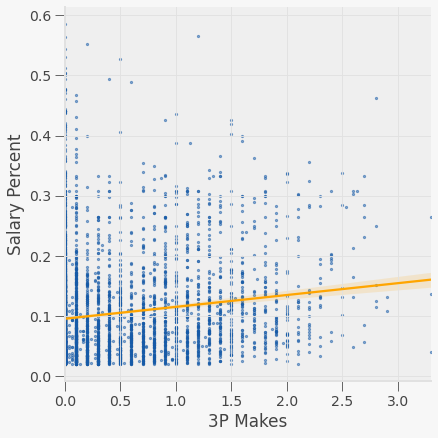

In [23]:
X = older_df.copy()
y = older_df['Salary Percent']

oldsimple_lr_model = linear_model.LinearRegression()

oldsimple_lr_model.fit(X[["3P Makes"]], y)

oldbeta_0 = oldsimple_lr_model.intercept_
oldbeta_1 = oldsimple_lr_model.coef_[0]

print(f"Old simple linear model: Salary Percent = {oldbeta_0:.4f} + {oldbeta_1:.4f} 3P Makes")

sns.lmplot(
    data=older_df, x="3P Makes", y="Salary Percent", height=6,
    scatter_kws=dict(s=5, alpha=0.5),
    line_kws={'color': 'orange'}
);

old_mse = metrics.mean_squared_error(y, oldsimple_lr_model.predict(X[['3P Makes']]))
print('Mean squared error is', old_mse)                             

In [24]:
X = newer_df.copy()
y = newer_df['Salary Percent']

newsimple_lr_model = linear_model.LinearRegression()

newsimple_lr_model.fit(X[["3P Makes"]], y)

newbeta_0 = newsimple_lr_model.intercept_
newbeta_1 = newsimple_lr_model.coef_[0]

print(f"New simple linear model: Salary Percent = {newbeta_0:.4f} + {newbeta_1:.4f} 3P Makes")

sns.lmplot(
    data=newer_df, x="3P Makes", y="Salary Percent", height=8,
    scatter_kws=dict(s=5, alpha=0.5),
    line_kws={'color': 'orange'}
);

new_mse = metrics.mean_squared_error(y, newsimple_lr_model.predict(X[['3P Makes']]))
print('Mean squared error is', new_mse)

New simple linear model: Salary Percent = 0.0833 + 0.0219 3P Makes
Mean squared error is 0.006293510029486172


Unfortunately the data is still not a great fit for this simple linear regression. However, it looks like our beta_1 is about 12% higher in our newer data compared to the older data. That is a good sign. Let's see how they fare when we include our other variables as well.

Before we generate some multivariate linear regressions, it is a good idea to check the correlation between each of our predictor variables, in order to eliminate variables that show signs of multicollinearity.

In [25]:
plt.subplots(figsize=(10,10))
sns.heatmap(clean_df.corr(), linewidths = 2)

<AxesSubplot:>

I will remove all salary information as we are using salary percentage as our dependent variable. I'll also remove Player, as player_id is an arbitrary number, and Year, as it is already factored into our two datasets. Finally, I'll remove Age for its high correlation with Experience, and 3P Attempts for its high correlation with 3P Makes.

<AxesSubplot:>

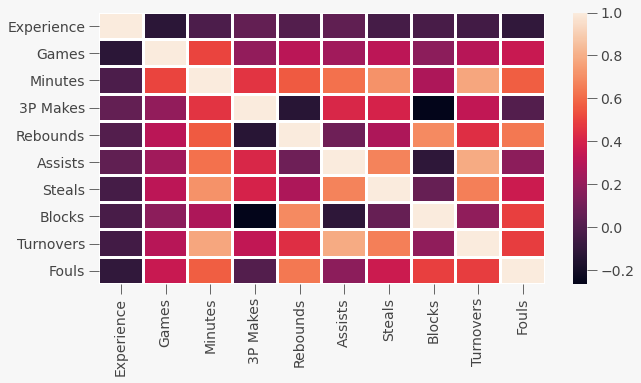

In [26]:
newindep_variables = newer_df.drop(['Salary', 'Salary Cap', 'Salary Percent', 'Year', 'Player', 'Age', '3P Attempts', 'Points'], axis=1)
oldindep_variables = older_df.drop(['Salary', 'Salary Cap', 'Salary Percent', 'Year', 'Player', 'Age', '3P Attempts', 'Points'], axis=1)
plt.subplots(figsize=(10,5))
sns.heatmap(newindep_variables.corr(), linewidths = 2)

## Multiple Linear Regression

Now that the predictor variables have been filtered, I will run a multiple linear regression on each of the old and new data.

In [27]:
X = oldindep_variables.copy()
y = older_df['Salary Percent']

categories = ['Experience', 'Games', 'Minutes Played', '3P Made', 
              'Rebounds', 'Assists', 'Steals', 'Blocks', 'Turnovers', 'Fouls']

oldmulti_regr = linear_model.LinearRegression()
oldmulti_regr.fit(X, y)

pairs = zip(categories, oldmulti_regr.coef_)

print('Old Intercept:', oldmulti_regr.intercept_)
for (category, coef) in pairs:
    print(category, ': ', coef)

Old Intercept: -0.01083027981862214
Experience :  0.006356229149073229
Games :  -0.00035442506394580287
Minutes Played :  0.0017468426427601413
3P Made :  0.010412184611248551
Rebounds :  0.006054133896862581
Assists :  0.002317022298807209
Steals :  -0.01885485384063002
Blocks :  0.02910799228369434
Turnovers :  0.026474773398563668
Fouls :  -0.009810582336634172


In [28]:
X = newindep_variables.copy()
y = newer_df['Salary Percent']

newmulti_regr = linear_model.LinearRegression()
newmulti_regr.fit(X, y)

pairs = zip(categories, newmulti_regr.coef_)

print('New Intercept:', newmulti_regr.intercept_)
for (category, coef) in pairs:
    print(category, ': ', coef)

New Intercept: -0.03617121782411255
Experience :  0.007216528291439452
Games :  -0.0004742823454764643
Minutes Played :  0.0028959302451106697
3P Made :  0.004759857038476971
Rebounds :  0.007801379347796547
Assists :  0.00036986302927898517
Steals :  -0.010678000581346946
Blocks :  0.010584607766033583
Turnovers :  0.02724818053296039
Fouls :  -0.01403652911810434


Interestingly, turnovers (a negative stat) have a positive coefficient. This likely can be explained by the high turnover count of elite players, as only top players handle the ball enough to generate a high turnover count.

3-points made are positive in both regressions, which is a good sign, however the coefficient is smaller in our newer data.

Let's compare our multivariate linear regressions with lasso regressions.

## Lasso Regression

In [29]:
X = oldindep_variables.copy()
y = older_df['Salary Percent']

oldlasso_model = linear_model.Lasso(alpha = 0.01)
oldlasso_model.fit(X, y)

oldlasso_coefs = pd.Series(dict(zip(list(X), oldlasso_model.coef_)))
oldlr_coefs = pd.Series(dict(zip(list(X), oldmulti_regr.coef_)))
oldlasso_vs_linreg = pd.DataFrame(dict(lasso=oldlasso_coefs, linreg=oldlr_coefs))
oldlasso_vs_linreg

lasso    linreg
Experience  0.005069  0.006356
Games      -0.000397 -0.000354
Minutes     0.003491  0.001747
3P Makes    0.000000  0.010412
Rebounds    0.006100  0.006054
Assists     0.000000  0.002317
Steals     -0.000000 -0.018855
Blocks      0.000000  0.029108
Turnovers   0.000000  0.026475
Fouls      -0.000000 -0.009811

In [30]:
X = newindep_variables.copy()
y = newer_df['Salary Percent']

newlasso_model = linear_model.Lasso(alpha = 0.01)
newlasso_model.fit(X, y)

newlasso_coefs = pd.Series(dict(zip(list(X), newlasso_model.coef_)))
newlr_coefs = pd.Series(dict(zip(list(X), newmulti_regr.coef_)))
newlasso_vs_linreg = pd.DataFrame(dict(lasso=newlasso_coefs, linreg=newlr_coefs))
newlasso_vs_linreg

lasso    linreg
Experience  0.006647  0.007217
Games      -0.000560 -0.000474
Minutes     0.004496  0.002896
3P Makes    0.000000  0.004760
Rebounds    0.005550  0.007801
Assists     0.000812  0.000370
Steals     -0.000000 -0.010678
Blocks      0.000000  0.010585
Turnovers   0.000000  0.027248
Fouls      -0.000000 -0.014037

Even with a low alpha regularization parameter of 0.01, the '3P Makes' column is thrown out in both the older and newer data. This is due to either a lack of prediction power in '3P Makes', or still too much multicollinearity between predictor variables.

Let's generate training and testing data to see how the mean squared error compares in our linear and lasso regressions.

In [31]:
# Compute MSE values for all 4 regressions

n_test = 75
X_train = X.iloc[:n_test, :]
X_test = X.iloc[n_test:, :]
y_train = y.iloc[:n_test]
y_test = y.iloc[n_test:]

oldmulti_regr.fit(X_train, y_train)
print('Old linear MSE train:', metrics.mean_squared_error(y_train, oldmulti_regr.predict(X_train)), ', '
    'MSE test:', metrics.mean_squared_error(y_test, oldmulti_regr.predict(X_test)))

Old linear MSE train: 0.0034287730803641498 , MSE test: 0.010252713402191525


In [32]:
oldlasso_model.fit(X_train, y_train)
print('Old lasso MSE train:', metrics.mean_squared_error(y_train, oldlasso_model.predict(X_train)), ', '
    'MSE test:', metrics.mean_squared_error(y_test, oldlasso_model.predict(X_test)))

Old lasso MSE train: 0.004165405010664216 , MSE test: 0.007019333696622415


In [33]:
newmulti_regr.fit(X_train, y_train)
print('New linear MSE train:', metrics.mean_squared_error(y_train, newmulti_regr.predict(X_train)), ', '
    'MSE test:', metrics.mean_squared_error(y_test, newmulti_regr.predict(X_test)))

New linear MSE train: 0.0034287730803641498 , MSE test: 0.010252713402191525


In [34]:
newlasso_model.fit(X_train, y_train)
print('New lasso MSE train:', metrics.mean_squared_error(y_train, newlasso_model.predict(X_train)), ', '
    'MSE test:', metrics.mean_squared_error(y_test, newlasso_model.predict(X_test)))

New lasso MSE train: 0.004165405010664216 , MSE test: 0.007019333696622415


Test MSE improves in the lasso models, which mean they are a more accurate measurement of the data.

## Conclusion

<div style="font-size: 15px">

I had a few interesting takeaways from this project.

1. The increase in 3-point shooting by year is evident, and the increase in both attempts and makes has been positive almost every year since 1990.

2. Stronger correlation and a higher beta_1 coefficient in the newer data of the simple linear regression point towards an increase in value for 3-point shooting when determining player contracts.

3. The relationship between 3-point shooting and player salary is hard to determine in the multiple linear and lasso regressions, likely due in part to the multicollinearity of predictor variables.


While I enjoyed analyzing NBA data on this project, I will have to continue to experiment with different predictor variables and time frames to see if more evidence of the relationship between 3-point shooting and player salary exists.